In [11]:
import pandas as pd

# Public dataset URL
url = "https://huggingface.co/datasets/Nicolybgs/healthcare_data/resolve/main/healthcare_data.csv"

# Load dataset directly from URL
df = pd.read_csv(url)

# Preview first 5 rows
df.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,NaN,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [12]:
df_clean = basic_cleaning(df)

print("Shape:", df_clean.shape)
print("Columns:\n", df_clean.columns.tolist())
df_clean.head()

Shape: (500000, 15)
Columns:
 ['Available Extra Rooms in Hospital', 'Department', 'Ward_Facility_Code', 'doctor_name', 'staff_available', 'patientid', 'Age', 'gender', 'Type of Admission', 'Severity of Illness', 'health_conditions', 'Visitors with Patient', 'Insurance', 'Admission_Deposit', 'Stay (in days)']


,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,NaN,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [13]:
# Make Stay numeric
df_clean["Stay (in days)"] = pd.to_numeric(
    df_clean["Stay (in days)"], errors="coerce"
)

# Create binary long_stay
df_clean["long_stay"] = (df_clean["Stay (in days)"] > 10).astype(int)

print("Long stay distribution:")
print(df_clean["long_stay"].value_counts())

Long stay distribution:
long_stay
0    366378
1    133622
Name: count, dtype: int64


In [15]:
results = train_evaluate_logistic_binary(
    df_clean,
    target_col="long_stay",
    drop_cols=["patientid", "Insurance", "Stay (in days)"],  # avoid leakage
    test_size=0.2,
    random_state=42
)

results["metrics"]

{'accuracy': 0.96357,
 'precision': 0.9696797037157625,
 'recall': 0.8915581499775482,
 'f1': 0.928979432693245,
 'roc_auc': 0.9549908458455241}

Dropped columns: ['patientid', 'Insurance', 'Stay (in days)']

Confusion Matrix:
 [[72531   745]
 [ 2898 23826]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     73276
           1       0.97      0.89      0.93     26724

    accuracy                           0.96    100000
   macro avg       0.97      0.94      0.95    100000
weighted avg       0.96      0.96      0.96    100000



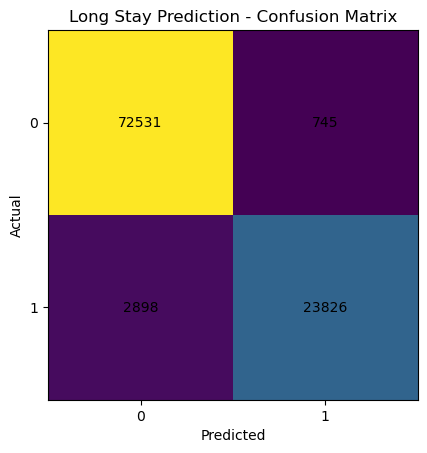

In [16]:
print("Dropped columns:", results["dropped_columns"])
print("\nConfusion Matrix:\n", results["confusion_matrix"])
print("\nClassification Report:\n", results["classification_report"])

plot_confusion_matrix(
    results["confusion_matrix"],
    title="Long Stay Prediction - Confusion Matrix"
)

ROC-AUC: 0.9549908458455241


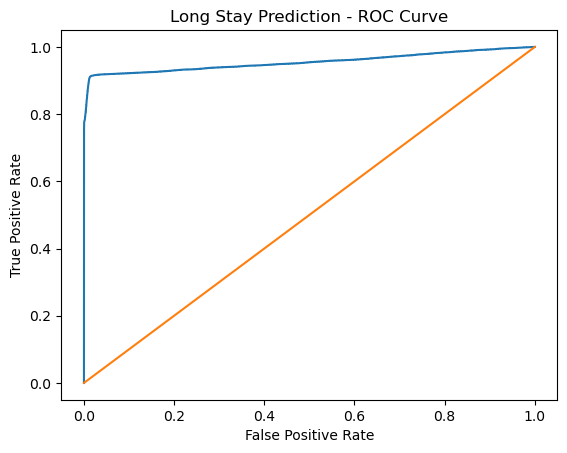

In [17]:
print("ROC-AUC:", results["metrics"]["roc_auc"])
plot_roc_curve(
    results["y_test"],
    results["y_proba"],
    title="Long Stay Prediction - ROC Curve"
)

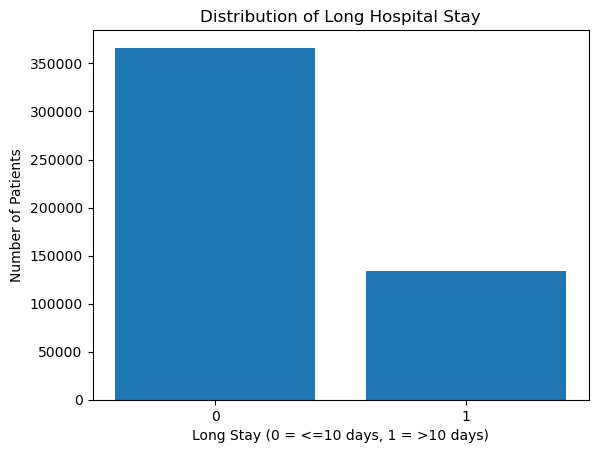

long_stay
0    366378
1    133622
Name: count, dtype: int64


In [18]:
import matplotlib.pyplot as plt

counts = df_clean["long_stay"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Long Stay (0 = <=10 days, 1 = >10 days)")
plt.ylabel("Number of Patients")
plt.title("Distribution of Long Hospital Stay")
plt.show()

print(counts)

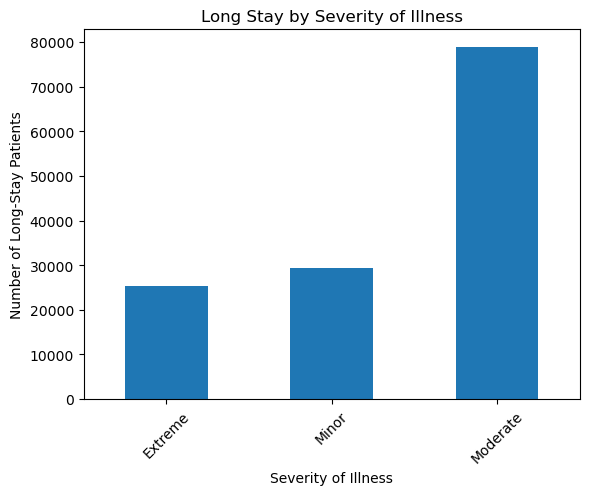

In [19]:
severity_long = (
    df_clean[df_clean["long_stay"] == 1]
    .groupby("Severity of Illness")["long_stay"]
    .count()
)

plt.figure()
severity_long.plot(kind="bar")
plt.xlabel("Severity of Illness")
plt.ylabel("Number of Long-Stay Patients")
plt.title("Long Stay by Severity of Illness")
plt.xticks(rotation=45)
plt.show()

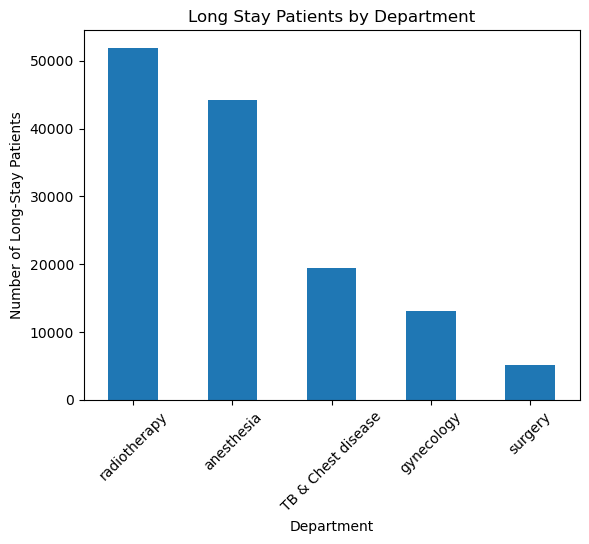

In [20]:
import matplotlib.pyplot as plt

dept_long = (
    df_clean[df_clean["long_stay"] == 1]
    .groupby("Department")["long_stay"]
    .count()
    .sort_values(ascending=False)
)

plt.figure()
dept_long.plot(kind="bar")
plt.xlabel("Department")
plt.ylabel("Number of Long-Stay Patients")
plt.title("Long Stay Patients by Department")
plt.xticks(rotation=45)
plt.show()

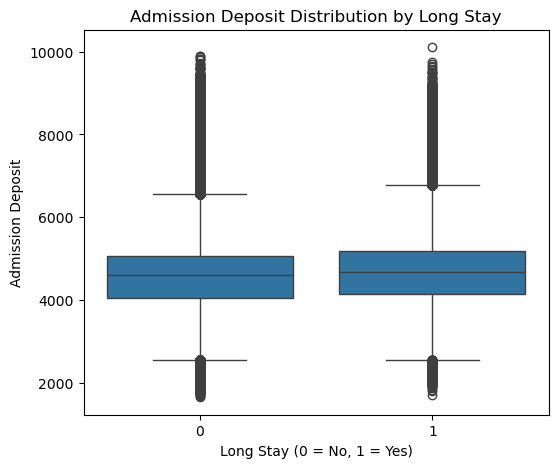

In [28]:
plt.figure(figsize=(6,5))
sns.boxplot(x="long_stay", y="Admission_Deposit", data=df_clean)
plt.title("Admission Deposit Distribution by Long Stay")
plt.xlabel("Long Stay (0 = No, 1 = Yes)")
plt.ylabel("Admission Deposit")
plt.show()

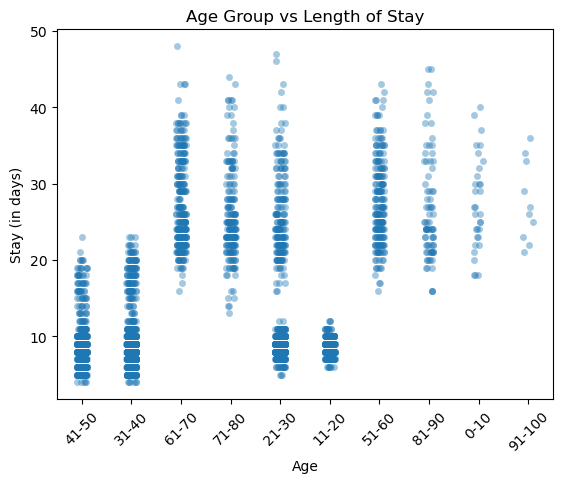

In [26]:
sns.stripplot(
    x="Age",
    y="Stay (in days)",
    data=sample_df,
    jitter=True,
    alpha=0.4
)
plt.xticks(rotation=45)
plt.title("Age Group vs Length of Stay")
plt.show()

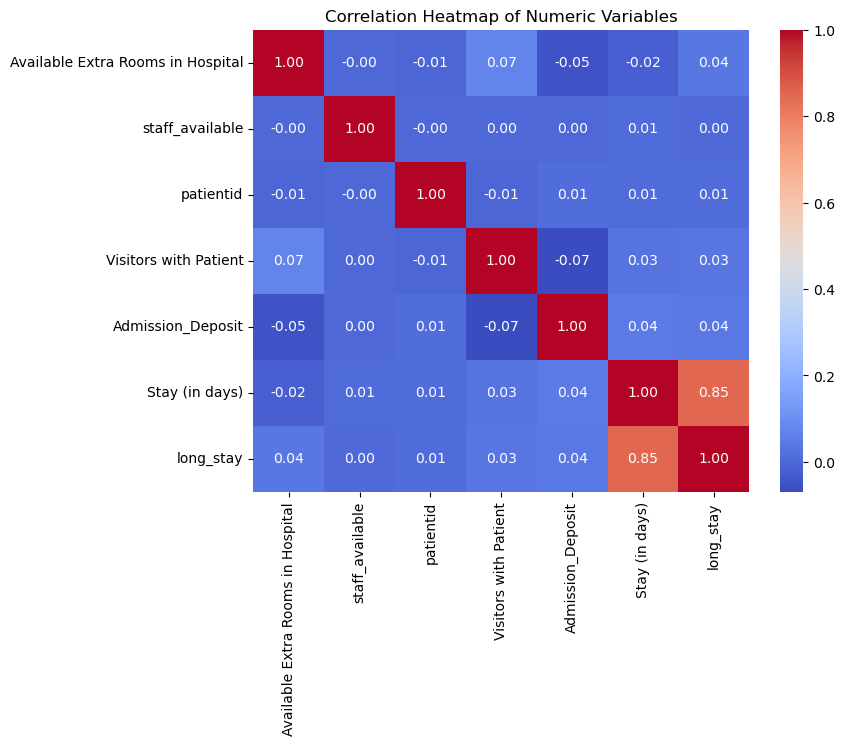

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
numeric_cols = df_clean.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()